# Lensing reconstruction

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from astropy.io import fits
from reproject import reproject_interp

# Cosmology
from astropy import cosmology as co
import astropy.units as uu

cd = co.FlatLambdaCDM(H0=70*uu.km/(uu.megaparsec * uu.s), Om0=0.3, Tcmb0 = 2.725*uu.K,\
                          Neff=3.05, m_nu=[0., 0., 0.06]*uu.eV, Ob0 = 0.0483)

Distance map

Note on the ellipticity

In astropy:

    a, b = r_eff, (1 - ellip) * r_eff

so b/a = 1- ellip

Image SP_A370_F160W.fits


<IPython.core.display.Javascript object>


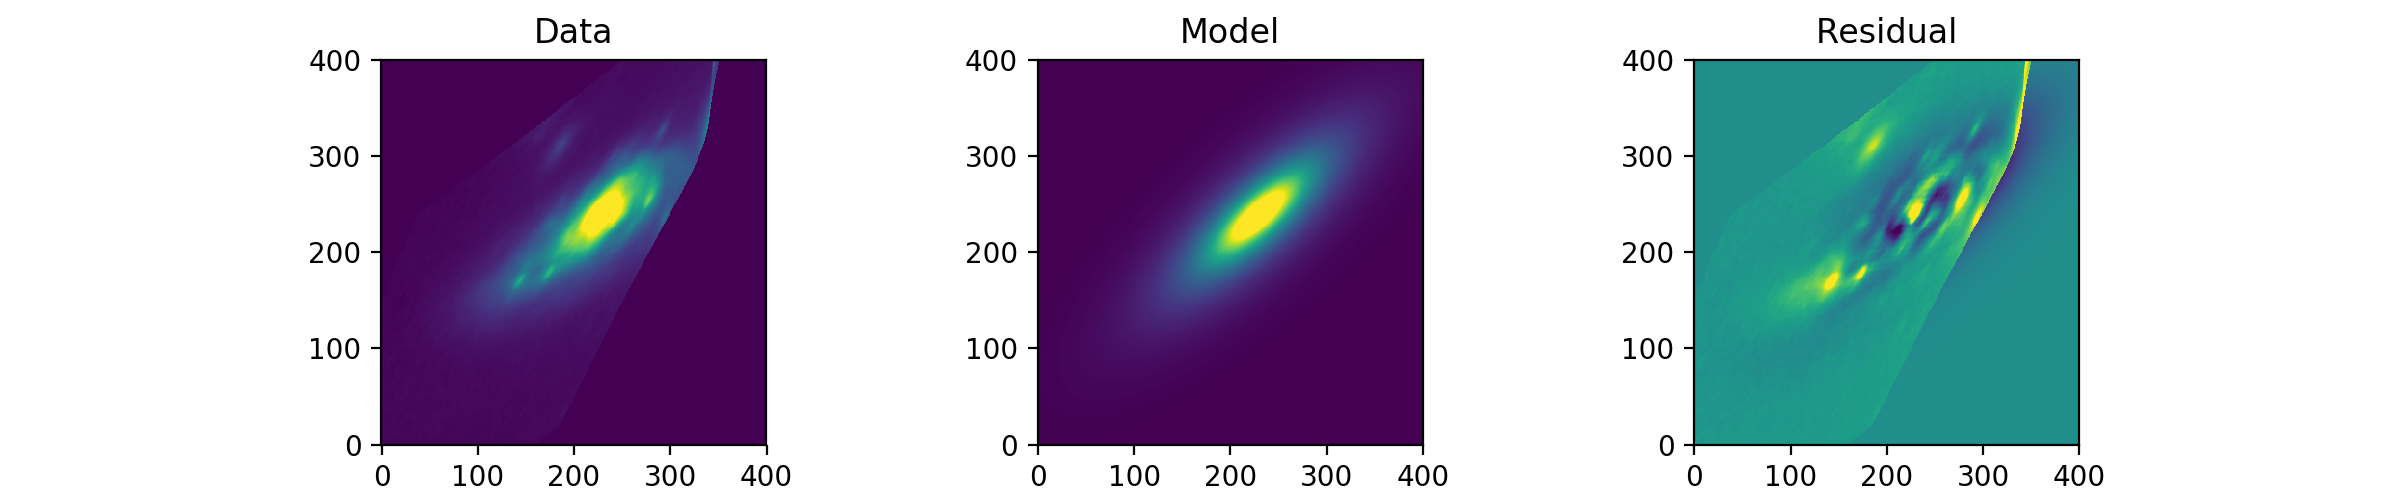

Fitted parameters
effective radius: 4.45 +/- 0.08 kpc
centre: [array(39.97149558), array(-1.5794747)]
theta: 0.74
inclination: 70.30 deg
inclination: 71.72 deg




In [4]:
import warnings
from astropy.modeling import models, fitting
from astropy.wcs import WCS

def fit_model(im_name,centre=(230,240)):

    print('Image %s'%im_name.split('SP_HST/')[-1])
    # Model
    p_init = models.Sersic2D(amplitude=0.1,r_eff=300,n=1.,x_0=centre[0],y_0=centre[1],ellip=0.6,theta=np.pi/4,fixed={'n':True})
    fit_p = fitting.LevMarLSQFitter()

    # Data
    im = fits.getdata(im_name)
    header = fits.getheader(im_name) 
    wcs = WCS(header)
    y, x = np.mgrid[:im.shape[0], :im.shape[1]]

    # Fit
    p = fit_p(p_init, x, y, im)

    # Plot the data with the best-fit model
    plt.figure(figsize=(12, 2.5))
    plt.subplot(1, 3, 1)
    plt.imshow(im, origin='lower', interpolation='nearest', vmin=0, vmax=0.1)
    plt.title("Data")
    plt.subplot(1, 3, 2)
    plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=0,vmax=0.1)
    plt.title("Model")
    plt.subplot(1, 3, 3)
    plt.imshow(im - p(x, y), origin='lower', interpolation='nearest', vmin=-0.02,vmax=0.02)
    plt.title("Residual")

    try:
        err_values = [np.sqrt(fit_p.fit_info['param_cov'][i][i]) for i in range(0,6) ]    
        err = { name:value for name,value in zip(p.param_names,err_values)}
        # Print results in physical units
        im_step = abs(header['CDELT1'])
        r_eff = p.r_eff.value * im_step*60*cd.kpc_proper_per_arcmin(0.611)
        r_eff_err = err['r_eff'] * im_step*60*cd.kpc_proper_per_arcmin(0.611)
        print('Fitted parameters')
        print('effective radius: %0.2f +/- %0.2f kpc'%(r_eff.value,r_eff_err.value))
        print('centre: %s'%wcs.all_pix2world(p.y_0.value,p.x_0.value,1))
        print('theta: %0.2f'%p.theta.value)
        print('inclination: %0.2f deg'%np.rad2deg(np.arccos(1-p.ellip.value)))
        print('inclination: %0.2f deg\n\n'%np.rad2deg(np.arccos(np.sqrt( ( (1- p.ellip.value)**2-0.13**2) / (1-0.13**2) ))))
        
        return p,err
    
    except TypeError:
        return p
 
    
fit = fit_model('../../Data/Lensing/A370/SP_HST/SP_A370_F160W.fits')

Image SP_A370_F160W_head_bigger.fits


<IPython.core.display.Javascript object>


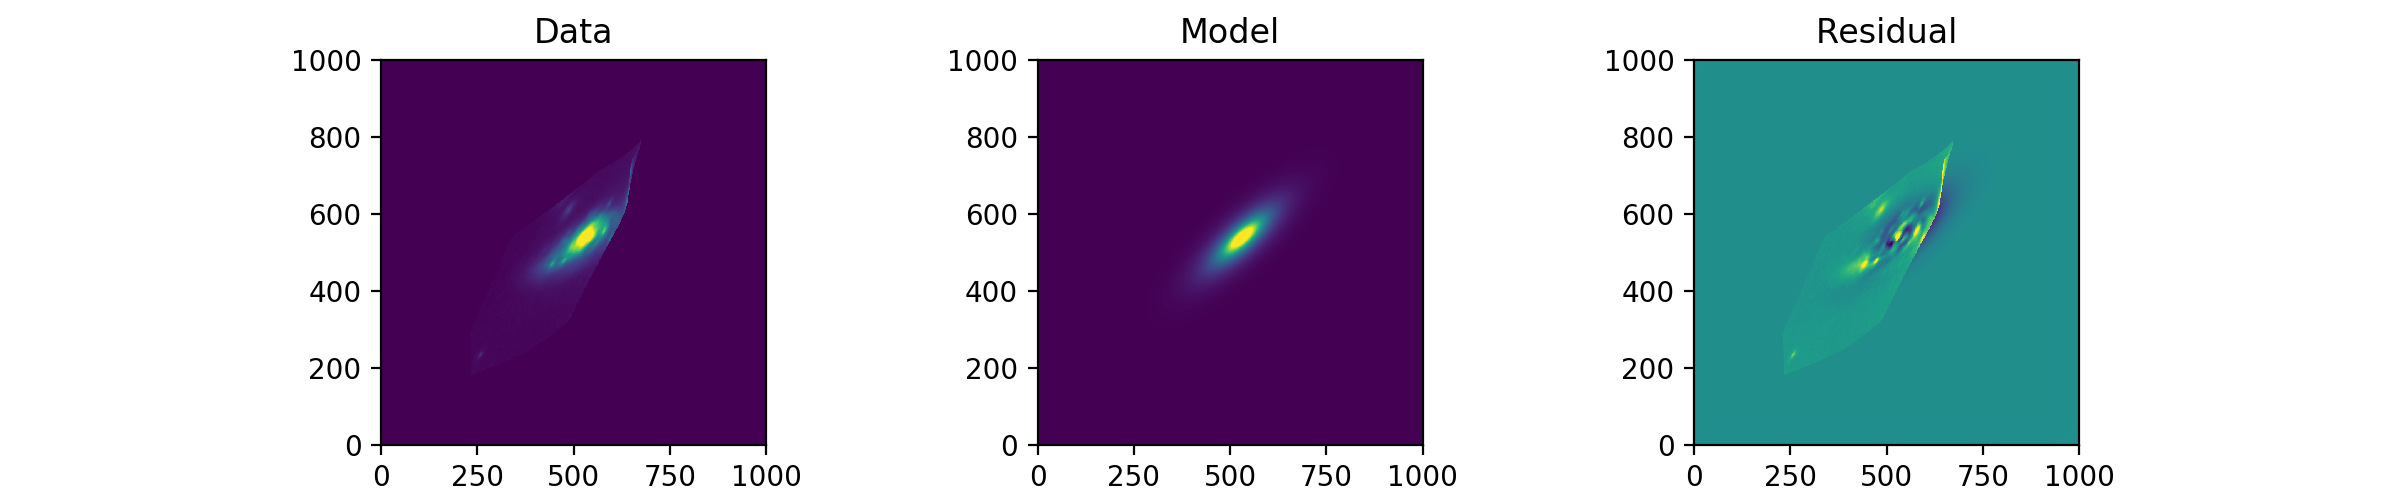

Fitted parameters
effective radius: 4.45 +/- 0.05 kpc
centre: [array(39.97149559), array(-1.57947473)]
theta: 0.74
inclination: 70.26 deg
inclination: 71.68 deg


amplitude:	0.0360	+/-	0.0004
  r_eff:	88.0607	+/-	0.0059
      n:	1.0000	+/-	0.0052
    x_0:	527.9400	+/-	0.3588
    y_0:	538.0909	+/-	1.0816
  ellip:	0.6623	+/-	0.3860
Theta 0.7395


<IPython.core.display.Javascript object>


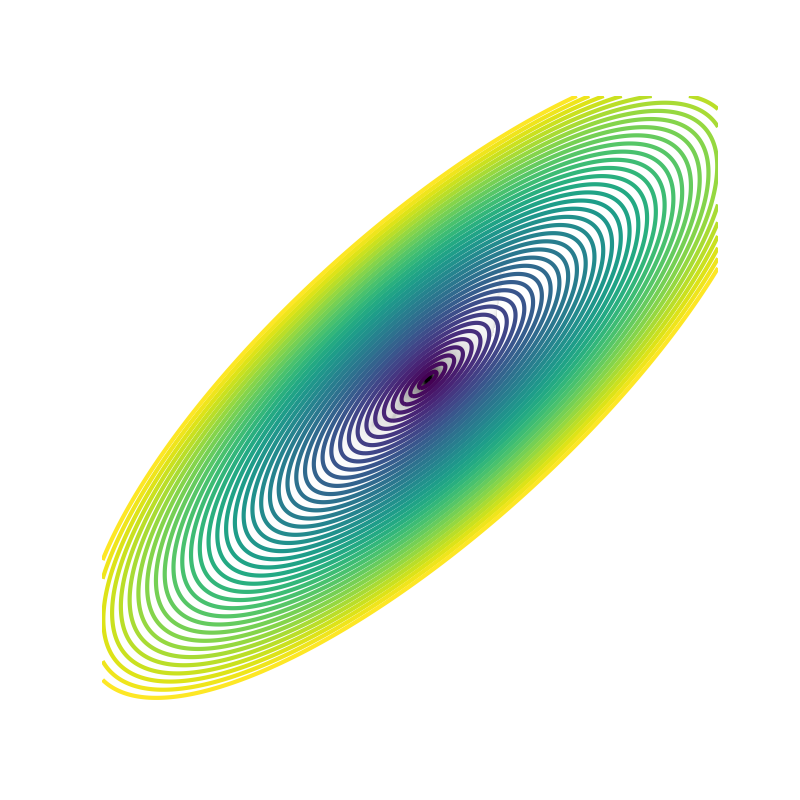

In [11]:
dummy_im     = fits.getdata('../../Data/Lensing/A370/SP_HST/SP_A370_F160W_head_bigger.fits')
dummy_header = fits.getheader('../../Data/Lensing/A370/SP_HST/SP_A370_F160W_head_bigger.fits')
kpc_per_pix = dummy_header['CDELT2'] * cd.kpc_proper_per_arcmin(0.725).to('kpc/deg')
p,err = fit_model('../../Data/Lensing/A370/SP_HST/SP_A370_F160W_head_bigger.fits',centre=(540,525))

for i,x,e in zip(p.param_names,p.parameters,err.values()):
    print('%7s:\t%0.4f\t+/-\t%0.4f'%(i,x,e))
print('Theta %0.4f'%p.theta.value)
    
def projected_distance(im,cx,cy,e,t,scale=1):
    i = 1-e
    x,y = np.meshgrid(range(dummy_im.shape[0]),range(dummy_im.shape[1]))
    x_rot = (x-cx)*np.cos(t)+(y-cy)*np.sin(t)
    y_rot = (y-cy)*np.cos(t)-(x-cx)*np.sin(t)
    return np.sqrt((x_rot)**2+((y_rot)/i)**2)*scale

# Distance map
dist_map = projected_distance(dummy_im,p.x_0,p.y_0,p.ellip,p.theta,kpc_per_pix.value)

# Plot
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(dummy_im,origin='lower',cmap='Greys',vmin=0,vmax=0.2)
cax = ax.contour(dist_map,origin='lower',levels=range(40))
ax.axis('off')

# Save maps
fits.writeto('A370_distance_kpc_source_plane.fits',data=dist_map,header=dummy_header,overwrite=True)

In [14]:
np.cos(np.arccos(0.2))

0.20000000000000015

Test how it looks with the metallicity map

<IPython.core.display.Javascript object>


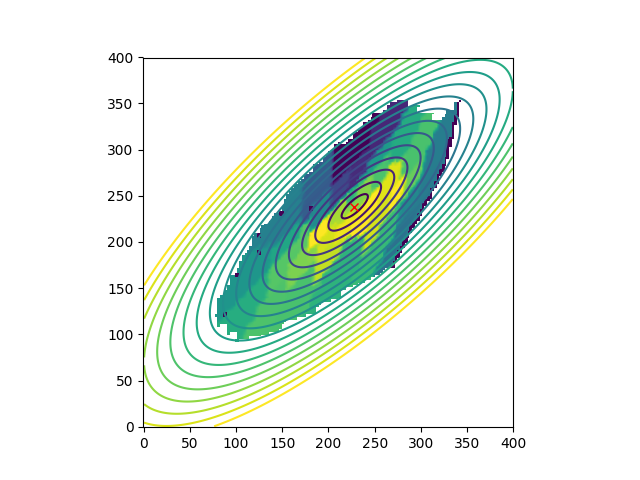

In [17]:
met, _ = reproject_interp('../../Data/Lensing/A370/SP_Maps/SP_Map_metallicity_head.fits',dummy_header)
met[np.where(met==0)]= np.nan
plt.figure()
plt.imshow(met,origin='lower',vmax=9,vmin=8.7)
plt.plot(p.x_0,p.y_0,marker='x',color='r')
plt.contour(dist_map,origin='lower',levels=range(20))

Explore how theta changes the map (always a mess)

<IPython.core.display.Javascript object>


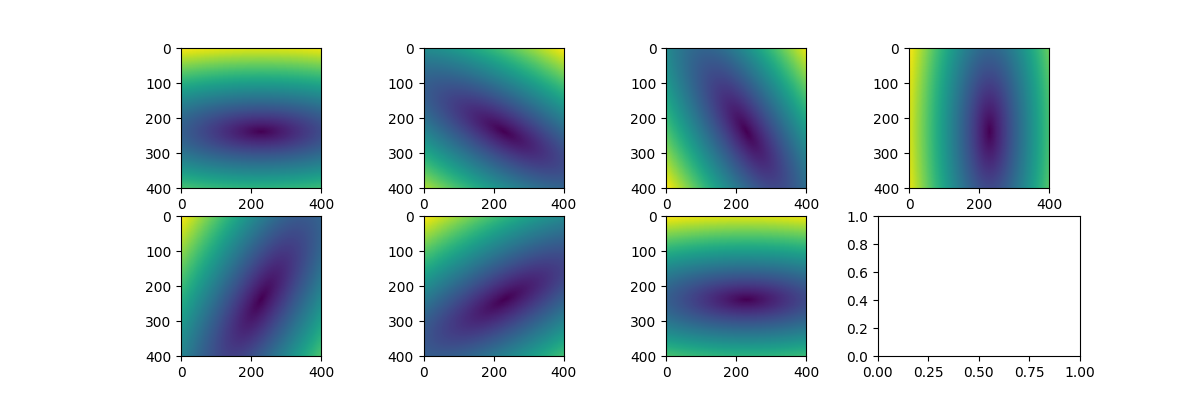

In [18]:
dist_map1 = projected_distance(dummy_im,p.x_0,p.y_0,p.ellip,0,kpc_per_pix.value)
dist_map2 = projected_distance(dummy_im,p.x_0,p.y_0,p.ellip,np.pi*1/6,kpc_per_pix.value)
dist_map3 = projected_distance(dummy_im,p.x_0,p.y_0,p.ellip,np.pi*2/6,kpc_per_pix.value)
dist_map4 = projected_distance(dummy_im,p.x_0,p.y_0,p.ellip,np.pi*3/6,kpc_per_pix.value)
dist_map5 = projected_distance(dummy_im,p.x_0,p.y_0,p.ellip,np.pi*4/6,kpc_per_pix.value)
dist_map6 = projected_distance(dummy_im,p.x_0,p.y_0,p.ellip,np.pi*5/6,kpc_per_pix.value)
dist_map7 = projected_distance(dummy_im,p.x_0,p.y_0,p.ellip,np.pi*6/6,kpc_per_pix.value)


fig, ax = plt.subplots(2,4,figsize=(12,4))
ax=ax.ravel()
ax[0].imshow(dist_map1)
ax[1].imshow(dist_map2)
ax[2].imshow(dist_map3)
ax[3].imshow(dist_map4)
ax[4].imshow(dist_map5)
ax[5].imshow(dist_map6)
ax[6].imshow(dist_map7)

<IPython.core.display.Javascript object>


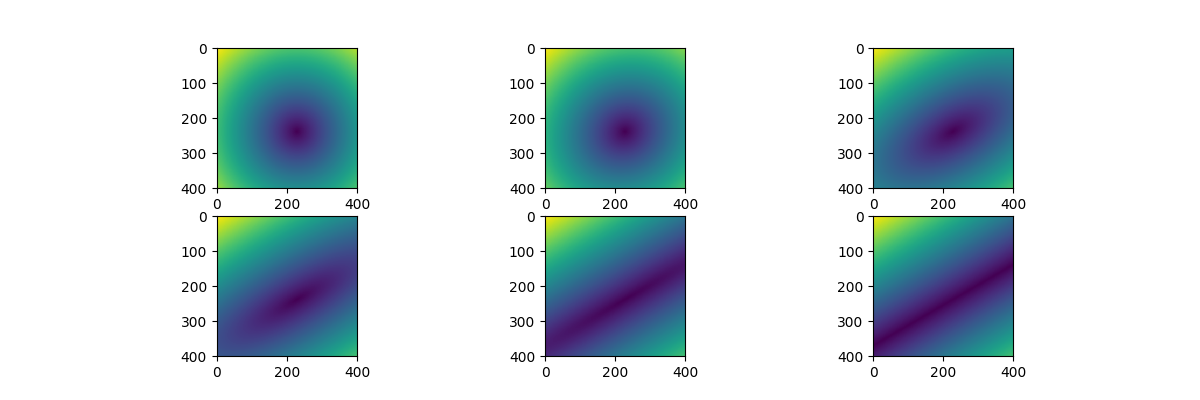

In [21]:
ellip_test = 0.7
dist_map1 = projected_distance(dummy_im,p.x_0,p.y_0,0.0,np.pi*5/6,kpc_per_pix.value)
dist_map2 = projected_distance(dummy_im,p.x_0,p.y_0,0.1,np.pi*5/6,kpc_per_pix.value)
dist_map3 = projected_distance(dummy_im,p.x_0,p.y_0,0.5,np.pi*5/6,kpc_per_pix.value)
dist_map4 = projected_distance(dummy_im,p.x_0,p.y_0,0.7,np.pi*5/6,kpc_per_pix.value)
dist_map5 = projected_distance(dummy_im,p.x_0,p.y_0,0.9,np.pi*5/6,kpc_per_pix.value)
dist_map6 = projected_distance(dummy_im,p.x_0,p.y_0,1,np.pi*5/6,kpc_per_pix.value)

fig, ax = plt.subplots(2,3,figsize=(12,4))
ax=ax.ravel()
ax[0].imshow(dist_map1)
ax[1].imshow(dist_map2)
ax[2].imshow(dist_map3)
ax[3].imshow(dist_map4)
ax[4].imshow(dist_map5)
ax[5].imshow(dist_map6)

Angular map in source plane (0 degrees north, 90 degrees east)

In [12]:
def empty_array(array):
    new = np.zeros_like(array)
    new[:,:] = np.nan
    return new

def sector_mask(im,cx,cy,angle_range):
    """
    From: https://stackoverflow.com/questions/18352973/mask-a-circular-sector-in-a-numpy-array
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x,y = np.ogrid[:im.shape[0],:im.shape[1]]
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    theta = np.arctan2(x-cx,y-cy) - tmin

    # zero aligned with north
    theta = theta- np.pi/2

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    return theta <= (tmax-tmin)

<IPython.core.display.Javascript object>


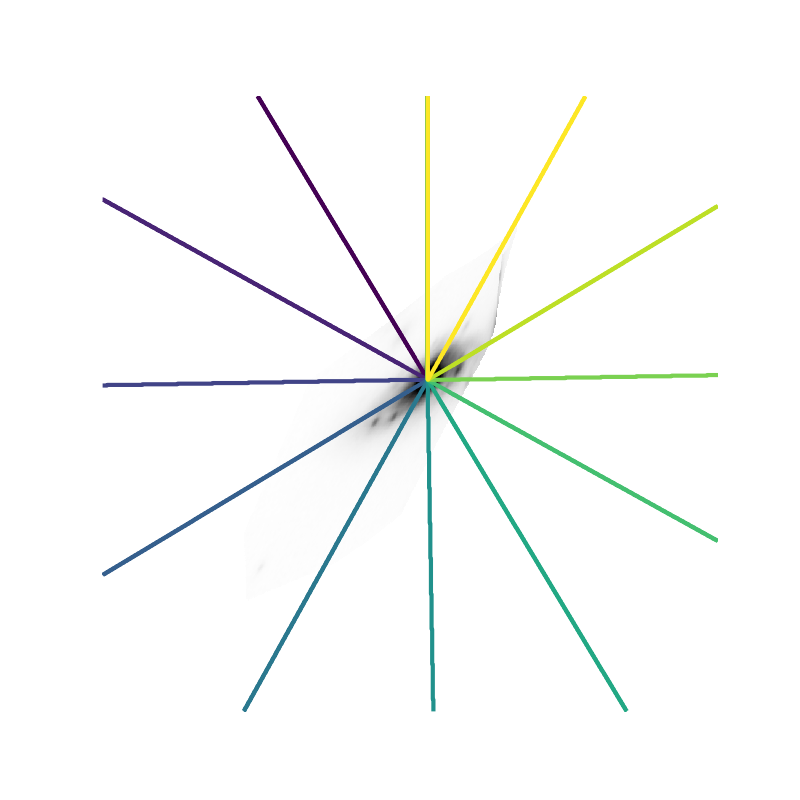

In [13]:
ang_map = empty_array(dummy_im)
for ang in np.arange(0,360,1):
    ang_map[sector_mask(dist_map,p.y_0,p.x_0,(ang,ang+1))] = ang

# Plot
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(dummy_im,origin='lower',cmap='Greys',vmin=0,vmax=0.1)
cax = ax.contour(ang_map,origin='lower',levels=np.arange(0,350,30))
ax.axis('off')

# Save maps
fits.writeto('A370_azimuth_map_source_plane.fits',data=ang_map,header=dummy_header,overwrite=True)

## Reconstruct the metallicity, extinction and SFR maps derived in a370_metallicity_maps_in_image_plane

In /Data/Lensing/A370 use the A370_MUSE.par to put the metallicity, extinction and SFR maps in source plane

for the distance map, use A370_simul.par


## Make a map of the different multiple images

<IPython.core.display.Javascript object>


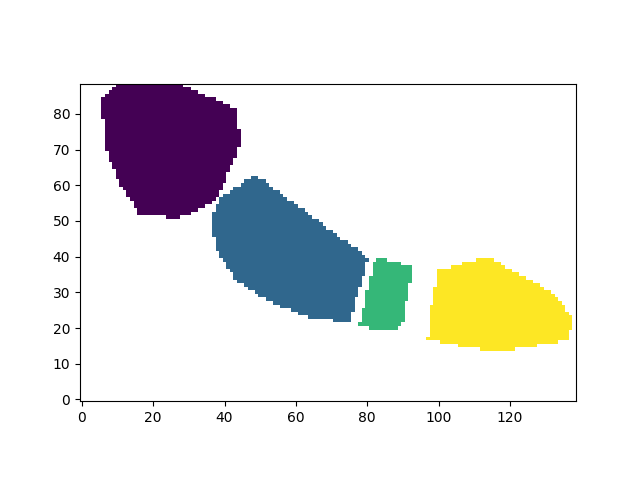

In [6]:
from matplotlib.patches import Polygon
from matplotlib.path import Path
from astropy.wcs import WCS

def plot_dwcs_region(imagefile,dwcsfile,ra_ref,dec_ref,im_levels=None,plot=False,color=False):
    '''
    To plot the weird dwcs lenstool files in normal coordinates.
    Parameters:
    -----------
    imagefile: string
        image where the regions were drawn
    dwcsfile: string
        contour file 
    ra_ref,dec_ref: float,float
        at the begingin of the lenstool main file (.par), where it says 'reference 3'
    im_levels: float,float
        for plotting the image
    Returns:
    --------
        polygon
    '''
    im = fits.getdata(imagefile)
    w = WCS(fits.getheader(imagefile))

    ## Read dwcs file 
    nb,cont_x,cont_y = np.loadtxt(dwcsfile,unpack=True)
            
    vertices = []
    for (x_rel,y_rel) in zip(cont_x,cont_y):
            ## putting it back to normal coordinates...
            ra  = x_rel/ (-3600*np.cos(dec_ref/180*np.pi)) + ra_ref
            dec = y_rel / 3600 + dec_ref
            ## Put back in image coordinates
            x,y = w.wcs_world2pix(ra,dec,1)
            vertices.append((x,y))
            #plt.plot(x,y,'ro',markersize=6)

    poly = Polygon(vertices,True,alpha=0.2,color='r',joinstyle='round')
    
    
    if plot:
        plt.figure()
        ax = plt .subplot(111)
        if im_levels == None:
                plt.imshow(im,aspect='equal')
        else:
                plt.imshow(im,aspect='equal',vmin=im_levels[0],vmax=im_levels[1])
        ax.add_collection(poly,autolim=False)
        plt.show()
    
    # Make polygon into a mask
    y, x = np.mgrid[:im.shape[0], :im.shape[1]]
    points = np.transpose((x.ravel(), y.ravel()))
    poly_path = Path(vertices)
    mask = poly_path.contains_points(points).reshape(im.shape)
    
    poly.set_facecolor('None')
    poly.set_linewidth(2)
    poly.set_alpha(1)
    if color is not False:
        poly.set_edgecolor(color)
    
    return poly,mask

reghead_poly,reghead = plot_dwcs_region('Maps/Map_metallicity.fits','../../Data/Lensing/A370/MUSEhead.dwcs',39.971340,-1.582260)
reg1_poly,reg1 = plot_dwcs_region('Maps/Map_metallicity.fits','../../Data/Lensing/A370/reg1.dwcs',39.971340,-1.582260)
reg2_poly,reg2 = plot_dwcs_region('Maps/Map_metallicity.fits','../../Data/Lensing/A370/reg2.dwcs',39.971340,-1.582260)
reg3_poly,reg3 = plot_dwcs_region('Maps/Map_metallicity.fits','../../Data/Lensing/A370/reg3.dwcs',39.971340,-1.582260)

fullmask = reghead*1. + reg1*2. + reg2*3. + reg3*4.
fullmask[np.where(fullmask==0)] = np.nan
fits.writeto('multiple_regions_mask.fits',fullmask,fits.getheader('Maps/Map_metallicity.fits'),overwrite=True)

plt.figure()
plt.imshow(fullmask,origin='lower')